In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import pandas as pd
import torch
from copy import deepcopy
from xopt.generators.bayesian import ExpectedImprovementGenerator
from xopt.vocs import VOCS

vocs = VOCS(
    variables = {"x":[0,1]},
    objectives = {"y":"MAXIMIZE"},
    constraints = {"c": ["LESS_THAN", 0]}
)

<Axes: >

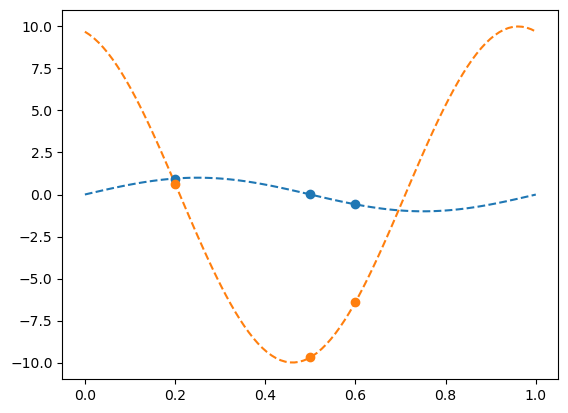

In [2]:
# define test functions
def y(x):
    return torch.sin(2*3.14*x)

def c(x):
    return 10.0*torch.cos(2*3.14*x + 0.25)

test_x = torch.linspace(*torch.tensor(vocs.bounds.flatten()), 100)

# define training data to pass to the generator
train_x = torch.tensor((0.2,0.5, 0.6))
train_y = y(train_x)
train_c = c(train_x)

data = pd.DataFrame(
    {"x": train_x.numpy(), "y": train_y.numpy(), "c": train_c}
)

def plot_ground_truth():
    fig,ax = plt.subplots()
    ax.plot(test_x, y(test_x),'--C0')
    ax.plot(test_x, c(test_x),'--C1')
    ax.plot(train_x, train_y,'oC0')
    ax.plot(train_x, train_c,'oC1')

    return ax
plot_ground_truth()

# Normal Model with Standard transforms and no constraints
- acquisition function is Expected Improvement

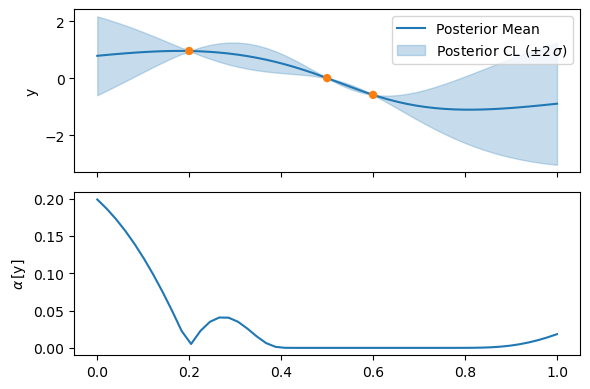

In [3]:
# plot the generator model and acquisition function
test_vocs = deepcopy(vocs)
test_vocs.constraints = {}
generator = ExpectedImprovementGenerator(vocs=test_vocs)
generator.add_data(data)
model = generator.train_model()
fig, ax = generator.visualize_model()

# Normal Model with Standard transforms and constraints

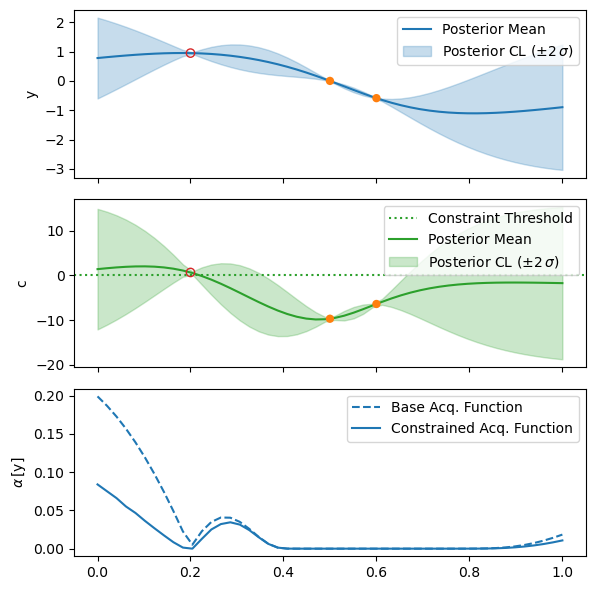

In [4]:
# plot the generator model and acquisition function
generator = ExpectedImprovementGenerator(vocs=deepcopy(vocs))
generator.add_data(data)
model = generator.train_model()
fig, ax = generator.visualize_model()

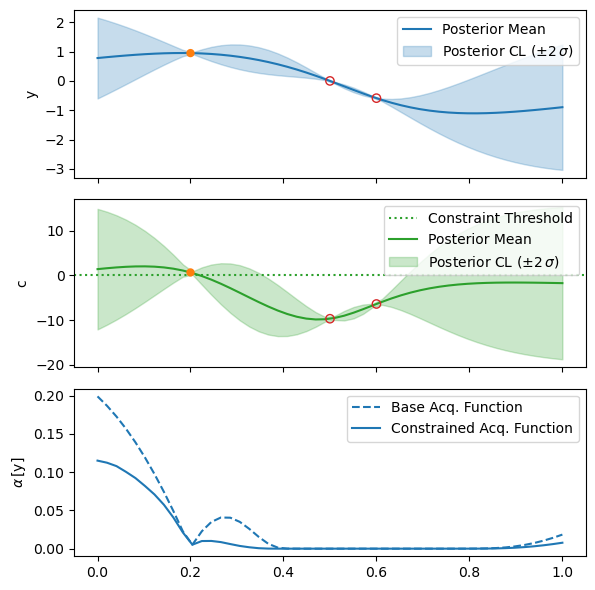

In [5]:
# plot the generator model and acquisition function
tvocs = deepcopy(vocs)
tvocs.constraints = {"c": ["GREATER_THAN", 0]}

generator = ExpectedImprovementGenerator(vocs=tvocs)
generator.add_data(data)
model = generator.train_model()
fig, ax = generator.visualize_model()

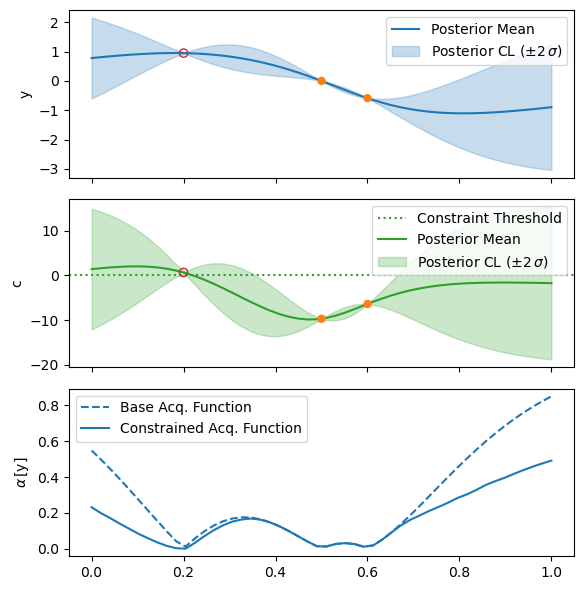

In [6]:
# plot the generator model and acquisition function
from xopt.generators.bayesian import BayesianExplorationGenerator
generator = BayesianExplorationGenerator(vocs=vocs)
generator.add_data(data)
model = generator.train_model()
fig, ax = generator.visualize_model()

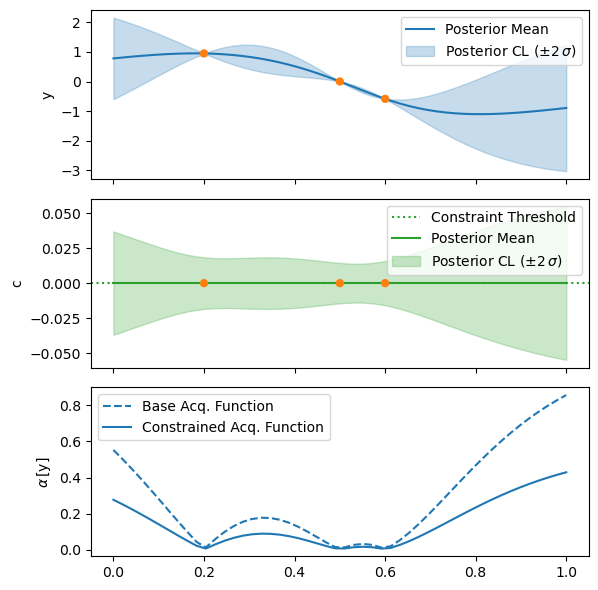

In [7]:
generator = BayesianExplorationGenerator(vocs=vocs)

data = pd.DataFrame(
    {"x": train_x.numpy(), "y": train_y.numpy(), "c": torch.zeros_like(train_y).numpy()}
)
generator.add_data(data)
model = generator.train_model()
fig, ax = generator.visualize_model()

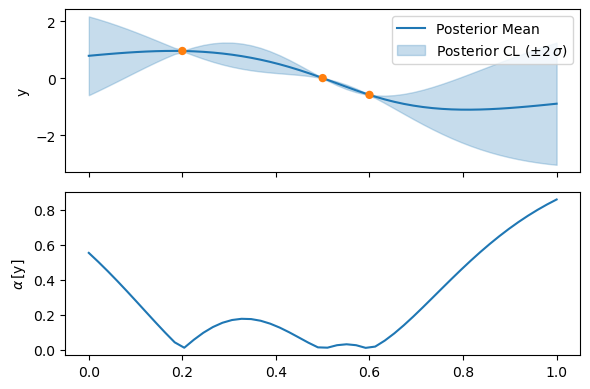

In [8]:
test_vocs = deepcopy(vocs)
test_vocs.constraints = {}
generator = BayesianExplorationGenerator(vocs=test_vocs)

data = pd.DataFrame(
    {"x": train_x.numpy(), "y": train_y.numpy(), "c": torch.zeros_like(train_y).numpy()}
)
generator.add_data(data)
model = generator.train_model()
fig, ax = generator.visualize_model()